# Linear systems

In [1]:
import numpy as np
from mylinalg_sol import solveLowerTriangular, solveUpperTriangular, lu, lu_solve

# Exercise: LU decomposition

Write a python program to solve it. 
Do not use any linear algebra packackes. 
Use your own linear algebra solvers in `mylinalg.py`.

$$
\boldsymbol{Ax}=
\begin{bmatrix}
2 & 4 & -2 \\
4 & 9 & -3 \\
-2 & -3 & 7 \\
\end{bmatrix}
\cdot
\begin{bmatrix}
x_{1} \\
x_2 \\
x_3 \\
\end{bmatrix}
=
\begin{bmatrix}
2 \\
8 \\
10 \\
\end{bmatrix}
= \boldsymbol{b}
$$

In [2]:
A = [[2,4,-2],[4,9,-3],[-2,-3,7]]

In [3]:
l, u = lu(A)

In [4]:
print(l,u)

[[ 1.  0.  0.]
 [ 2.  1.  0.]
 [-1.  1.  1.]] [[ 2.  4. -2.]
 [ 0.  1.  1.]
 [ 0.  0.  4.]]


Check $LU = A$

In [5]:
print(np.dot(l,u))
print(A)

[[ 2.  4. -2.]
 [ 4.  9. -3.]
 [-2. -3.  7.]]
[[2, 4, -2], [4, 9, -3], [-2, -3, 7]]


In [6]:
b = np.array([2,8,10])
x = lu_solve(A,b)
print(x)

[-1.  2.  2.]


compare your solution with scipy

In [7]:
from scipy.linalg import lu as scipy_lu
from scipy.linalg import lu_factor as scipy_lu_factor
from scipy.linalg import lu_solve as scipy_lu_solve
from scipy.linalg import solve as scipy_solve

In [8]:
P, L, U = scipy_lu(A)

# A = PLU
print(np.dot(P,np.dot(L,U)))
print(A)

[[ 2.  4. -2.]
 [ 4.  9. -3.]
 [-2. -3.  7.]]
[[2, 4, -2], [4, 9, -3], [-2, -3, 7]]


In [9]:
b = np.array([2,8,10])
lu, piv = scipy_lu_factor(A)
x = scipy_lu_solve((lu, piv), b)
print(x)

[-1.  2.  2.]


In [10]:
x = scipy_solve(A,b)
print(x)

[-1.  2.  2.]


# Apply to the Laplace's equation

Copy your previous codes in `project3_demo1.ipynb` but use your own linear algebra solver.

In [11]:
import numpy as np
from scipy.sparse import dia_array  # if dia_array is not able, use dia_matrix
from scipy.sparse import dia_matrix
from numba import jit, njit, prange
import matplotlib.pyplot as plt

In [12]:
def generate_1_4_1_dia(usize=4):
    ex = np.ones(usize)
    data = np.array([-ex, 4 * ex, -ex])
    offsets = np.array([-1, 0, 1])
    A = dia_array((data, offsets), shape=(usize, usize)).toarray()
    return A

def generate_the_laplace_matrix_with_size(N=4):
    """
    assume sqrt(N) is an integer.

    """
    nsq = N*N
    A   = np.zeros((nsq,nsq))
    u   = generate_1_4_1_dia(N)

    d_matrix = generate_1_4_1_dia(N)
    o_matrix = -np.identity(N)
    z_matrix = np.zeros((N,N))

    init_matrix_kernel(N,A,u,d_matrix,o_matrix,z_matrix)
    return A

@njit(parallel=True)
def init_matrix_kernel(N,A,u,d_matrix,o_matrix, z_matrix):
    for i in prange(N):
        for j in prange(N):
            if u[i,j] == 4:
                # the elemen is another 1_4_1 matrix
                suba = d_matrix
            elif u[i,j] == -1:
                suba = o_matrix
            else:
                suba = z_matrix
            
            for i2 in range(N):
                for j2 in range(N):
                    ii = i2 + i*N
                    jj = j2 + j*N
                    A[ii,jj] = suba[i2,j2]
    return A

def generate_the_rhs_vector_with_size(N=4):
    b = np.zeros(N*N)
    b[-N:] = 1
    return b

def convert_solution(x):
    usize = np.sqrt(len(x))
    u = x.reshape(int(usize),int(usize)).transpose()
    return u


In [13]:
def solve_laplace(N=16):
    A = generate_the_laplace_matrix_with_size(N=N)
    b = generate_the_rhs_vector_with_size(N=N)
    #x = linalg.solve(A,b) # use scipy
    x = lu_solve(A,b)      # use our solver
    u = convert_solution(x)
    return u

In [14]:
u = solve_laplace(N=16)

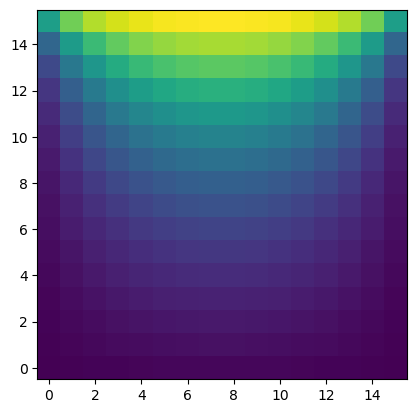

In [15]:
plt.imshow(u.T,origin="lower")

You could see that our solver is much slower than `scipy.linalg`. Could you speed it up?